# Decision Tree

In [1]:
# General
import pandas as pd
import numpy as np
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import preprocessing

# DecissionTree model
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# T-test
import scipy.stats as stats
from scipy.stats import t

%matplotlib inline

In [2]:
# Import data to DataFrame
data=pd.read_csv('DATA/TargetedMailing.csv')
data.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,FirstPurchaseYear,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,Age,Country,Buyer
0,M,M,90000.0,2,2011,0,Bachelors,Professional,1,0,1-2 Miles,46,AU,1
1,S,M,60000.0,3,2011,3,Bachelors,Professional,0,1,0-1 Miles,42,AU,1
2,M,M,60000.0,3,2011,3,Bachelors,Professional,1,1,2-5 Miles,47,AU,1
3,S,F,70000.0,0,2010,0,Bachelors,Professional,0,1,5-10 Miles,45,AU,1
4,S,F,80000.0,5,2011,5,Bachelors,Professional,1,4,1-2 Miles,39,AU,1


In [3]:
# Categorical and Numerical variables
data.Buyer=data.Buyer.astype(object) # set Buyer as object

cat_cols=data.select_dtypes(include=['object']).columns.tolist()
num_cols=data.select_dtypes(exclude=['object']).columns.tolist()

print('Categorical variables:',cat_cols)
print('Numerical variables:',num_cols)

Categorical variables: ['MaritalStatus', 'Gender', 'Education', 'Occupation', 'CommuteDistance', 'Country', 'Buyer']
Numerical variables: ['YearlyIncome', 'TotalChildren', 'FirstPurchaseYear', 'NumberChildrenAtHome', 'HouseOwnerFlag', 'NumberCarsOwned', 'Age']


In [4]:
# Encoding categorical data
label_encoder = preprocessing.LabelEncoder()

for cols in cat_cols:
    data_encoded=label_encoder.fit_transform(data[cols]).tolist()
    data=data.join(pd.Series(data_encoded).rename(cols+'_enc'))
data=data.drop(cat_cols, axis=1)

In [5]:
# Define input and output variables
y_colname=data.columns[-1]
x_colname=data.columns[:-1]

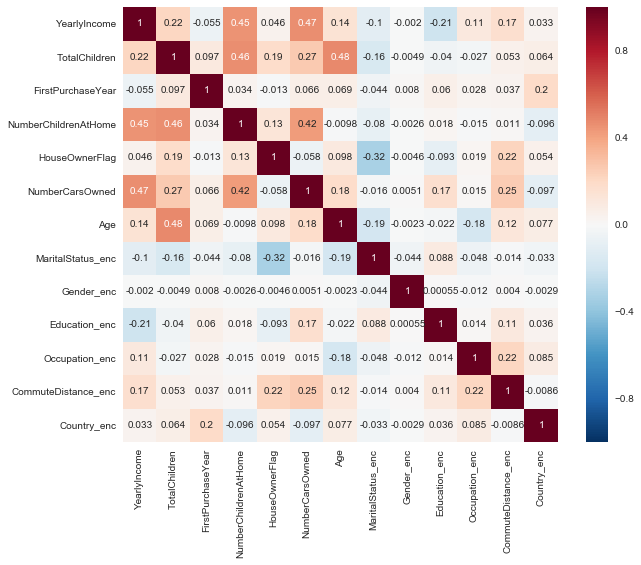

In [6]:
# Correlation matrix
corrmat=data[x_colname].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, annot=True, square=True)

### Decision Tree model

In [7]:
# train model
X_train, X_test, y_train, y_test = train_test_split(data[x_colname], data[y_colname], test_size=0.3)
clf_tree=DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.8761269383339344

In [8]:
# Accuracy
print('Accuracy of Decision Tree classifier on test set: {:.3f}'.format(clf_tree.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.876


In [9]:
# Which features are the most important in model?
feature_importance=pd.DataFrame({'importance':clf_tree.feature_importances_, 'feature':x_colname})
feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,FirstPurchaseYear,0.461655
1,Age,0.115000
2,YearlyIncome,0.075409
3,CommuteDistance_enc,0.050761
4,NumberCarsOwned,0.050343
5,TotalChildren,0.041430
6,NumberChildrenAtHome,0.038776
7,Country_enc,0.036741
8,Gender_enc,0.033096
9,MaritalStatus_enc,0.032946


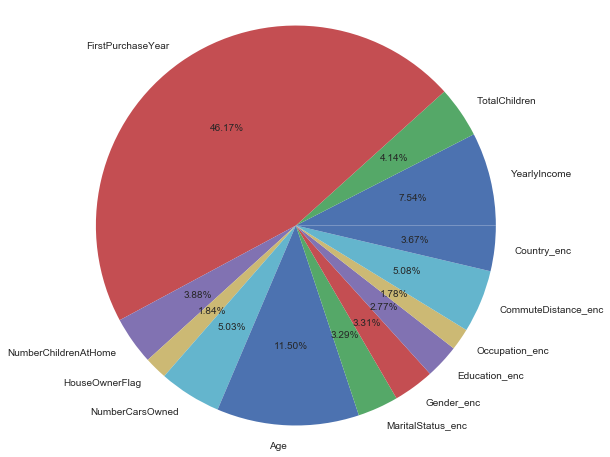

In [10]:
# Which features are the most important in model?
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(feature_importance['importance'], labels=feature_importance['feature'], autopct='%1.2f%%')
ax1.axis('equal');

In [11]:
# Parameter optimization
from sklearn.model_selection import GridSearchCV
parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': np.arange(1,clf_tree.tree_.max_depth+1),
              'max_features':np.arange(1, clf_tree.max_features_+1)
             }
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters)
clf.fit(X_train, y_train)
print("Best criterion parameter: ", clf.best_params_['criterion'])
print("Best max_depth parameter: ", clf.best_params_['max_depth'])
print("Best max_features parameter: ", clf.best_params_['max_features'])

Best criterion parameter:  entropy
Best max_depth parameter:  19
Best max_features parameter:  11


In [12]:
# Make 100x trials before Parameter optimization
clf_tree=DecisionTreeClassifier()
before=[]
for i in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(data[x_colname], data[y_colname], test_size=0.3)
    clf_tree.fit(X_train, y_train)
    before.append(clf_tree.score(X_test, y_test))
print('Average accuracy score before parameter optimization:', np.mean(before))

Average accuracy score before parameter optimization: 0.8691904075009015


In [13]:
# Make 100x trials after Parameter optimization
clf_tree=DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], max_features=clf.best_params_['max_features'], criterion=clf.best_params_['criterion'])
after=[]
for i in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(data[x_colname], data[y_colname], test_size=0.3)
    clf_tree.fit(X_train, y_train)
    after.append(clf_tree.score(X_test, y_test))
print('Average accuracy score after parameter optimization:', np.mean(after))

Average accuracy score after parameter optimization: 0.8714136314460872


### T-test - check whether there is significant difference after parameter optimization

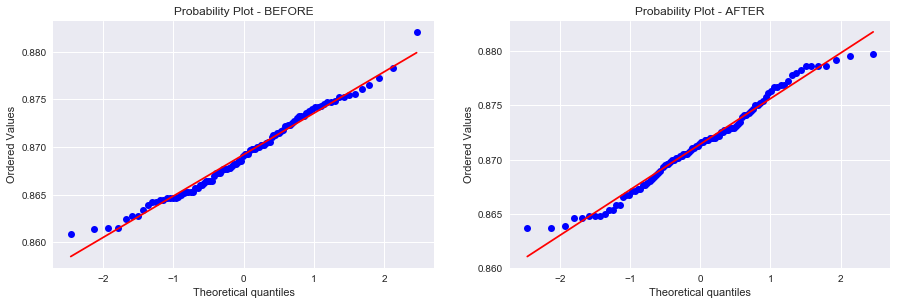

In [14]:
# check whether distribution follows normal distribution
plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
stats.probplot(before, plot=plt)
plt.title('Probability Plot - BEFORE')
ax2 = plt.subplot(222)
stats.probplot(after, plot=plt)
plt.title('Probability Plot - AFTER');

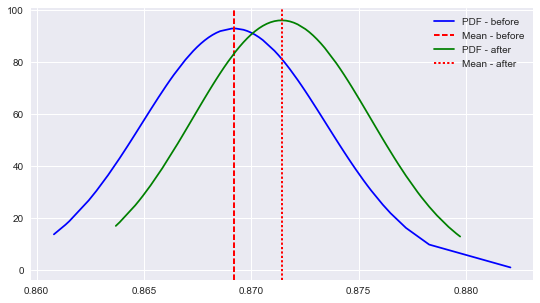

In [15]:
# plot PDFs(Probability Density Function) and means of both distributions
before=np.sort(before)
after=np.sort(after)

pdf_b=stats.norm.pdf(before, np.mean(before), np.std(before))
pdf_a=stats.norm.pdf(after, np.mean(after), np.std(after))

plt.figure(figsize=(9,5))
plt.plot(before, pdf_b, color='blue', label='PDF - before')
plt.axvline(np.mean(before), color = "r", linestyle = "dashed", linewidth = 2, label='Mean - before')
plt.plot(after, pdf_a, color='green', label='PDF - after')
plt.axvline(np.mean(after), color = "r", linestyle = "dotted", linewidth = 2, label='Mean - after')
plt.legend()
plt.show()

In [16]:
# count T-test characteristics
t_stat,p_value=stats.ttest_ind(a= after, b= before)
print('t-statistic:',t_stat)
print('p-value:',p_value)

t-statistic: 3.7039708655599277
p-value: 0.0002752541869859184


Null hypothesis: There is no improvement after parameter optimization

Alternative hypothesis: There is improvement after parameter optimization

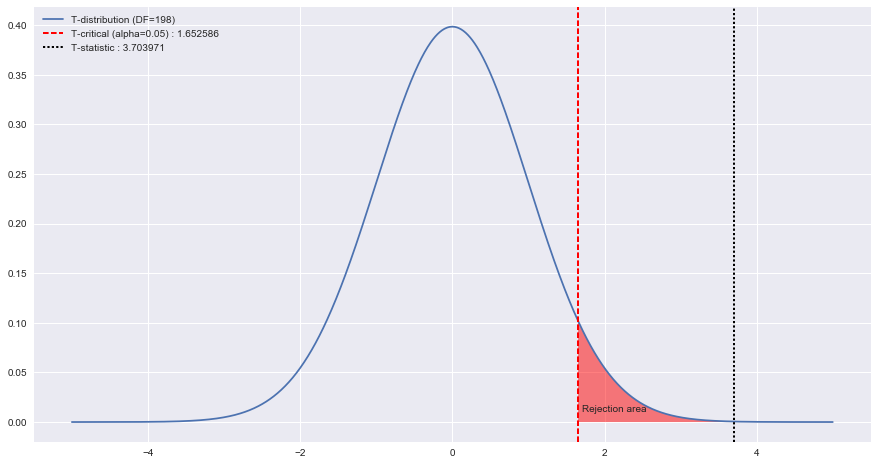

In [17]:
# count t-critical value
alpha = 0.05
df = len(before)+len(after)-2
t_critical = t.ppf(1-alpha, df)

# plot t distribution
t_dist = t(198)
t_values = np.linspace(-5, 5, 1000)
plt.figure(figsize=(15,8))
plt.plot(t_values, t_dist.pdf(t_values), label='T-distribution (DF=%d)'%df)

# plot rejection area
plt.fill_between(x=np.arange(t_critical,5,0.01), 
                 y1= t_dist.pdf(np.arange(t_critical,5,0.01)) ,
                 facecolor='red',
                 alpha=0.5)
plt.text(x=1.7, y=0.01, s= "Rejection area")

# plot t-critical value
plt.axvline(t_critical, color = "r", linestyle = "dashed", linewidth = 2, label='T-critical (alpha=0.05) : %f'%t_critical)
# plot t-statistic value
plt.axvline(t_stat, color = "black", linestyle = "dotted", linewidth = 2, label='T-statistic : %f'%t_stat)

plt.legend()
plt.show()

In [18]:
# Conclusion
print ('Conclusion based on t-statistic value:')
if t_stat < t_critical:
    print('We accept null hypothesis - improvement after parameter optimization is not statistically significant')
else:
    print('We reject null hypothesis - improvement after parameter optimization is statistically significant') 
print()
print ('Conclusion based on p-value:')
if p_value > alpha:
    print('We accept null hypothesis - improvement after parameter optimization is not statistically significan')
else:
    print('We reject null hypothesis - improvement after parameter optimization is statistically significant') 

Conclusion based on t-statistic value:
We reject null hypothesis - improvement after parameter optimization is statistically significant

Conclusion based on p-value:
We reject null hypothesis - improvement after parameter optimization is statistically significant
